In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from keras.utils import to_categorical
from keras import applications, optimizers

from keras.models import Sequential, Model, load_model,clone_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from keras.losses import categorical_crossentropy

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import applications
from keras.applications.resnet50 import ResNet50
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [35]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

### Extracting Train Data

In [9]:
import os
import pandas as pd

# Assuming 'foldernames' is a list of categories
foldernames = os.listdir('C:/Users/gaya Gopan/Documents/PYTHON/raw-img') 
categories = []
files = []

for k, folder in enumerate(foldernames):
    filenames = os.listdir("raw-img/" + folder)
    for file in filenames:
        files.append("raw-img/" + folder + "/" + file)
        categories.append(k)

df = pd.DataFrame({'filename': files, 'category': categories})

# Initialize empty train df
train_df = pd.DataFrame(columns=['filename', 'category'])

# Collecting 500 samples from each of 10 categories
for i in range(10):
    # Use concat instead of append
    train_df = pd.concat([train_df, df[df['category'] == i].iloc[:500, :]])

print(train_df.head())
train_df = train_df.reset_index(drop=True)  # Reset index of a Data Frame

print(train_df)

                                           filename category
0      raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg        0
1  raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg        0
2  raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg        0
3  raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg        0
4  raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg        0
                                               filename category
0          raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg        0
1      raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg        0
2      raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg        0
3      raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg        0
4      raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg        0
...                                                 ...      ...
4995  raw-img/scoiattolo/OIP-DLuAMgbGGOGW0r49pIsMtgH...        9
4996  raw-img/scoiattolo/OIP-DlVY-0x9uqexVnZY_1TXxgH...        9
4997  raw-img/scoiattolo/OIP-DlwICIPtlrWDrdz6v-QV

In [10]:
y = train_df['category']
x = train_df['filename']

x, y = shuffle(x, y, random_state=8)

In [11]:
def centering_image(img):
    size = [256,256]
    
#shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
#creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img 

    return resized

In [12]:
images = []

with tqdm(total=len(train_df)) as k:  
    for i, file_path in enumerate(train_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

C:\Users\Gaya Gopan\AppData\Local\Temp\ipykernel_14752\1365171311.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(train_df)) as k:


  0%|          | 0/5000 [00:00<?, ?it/s]

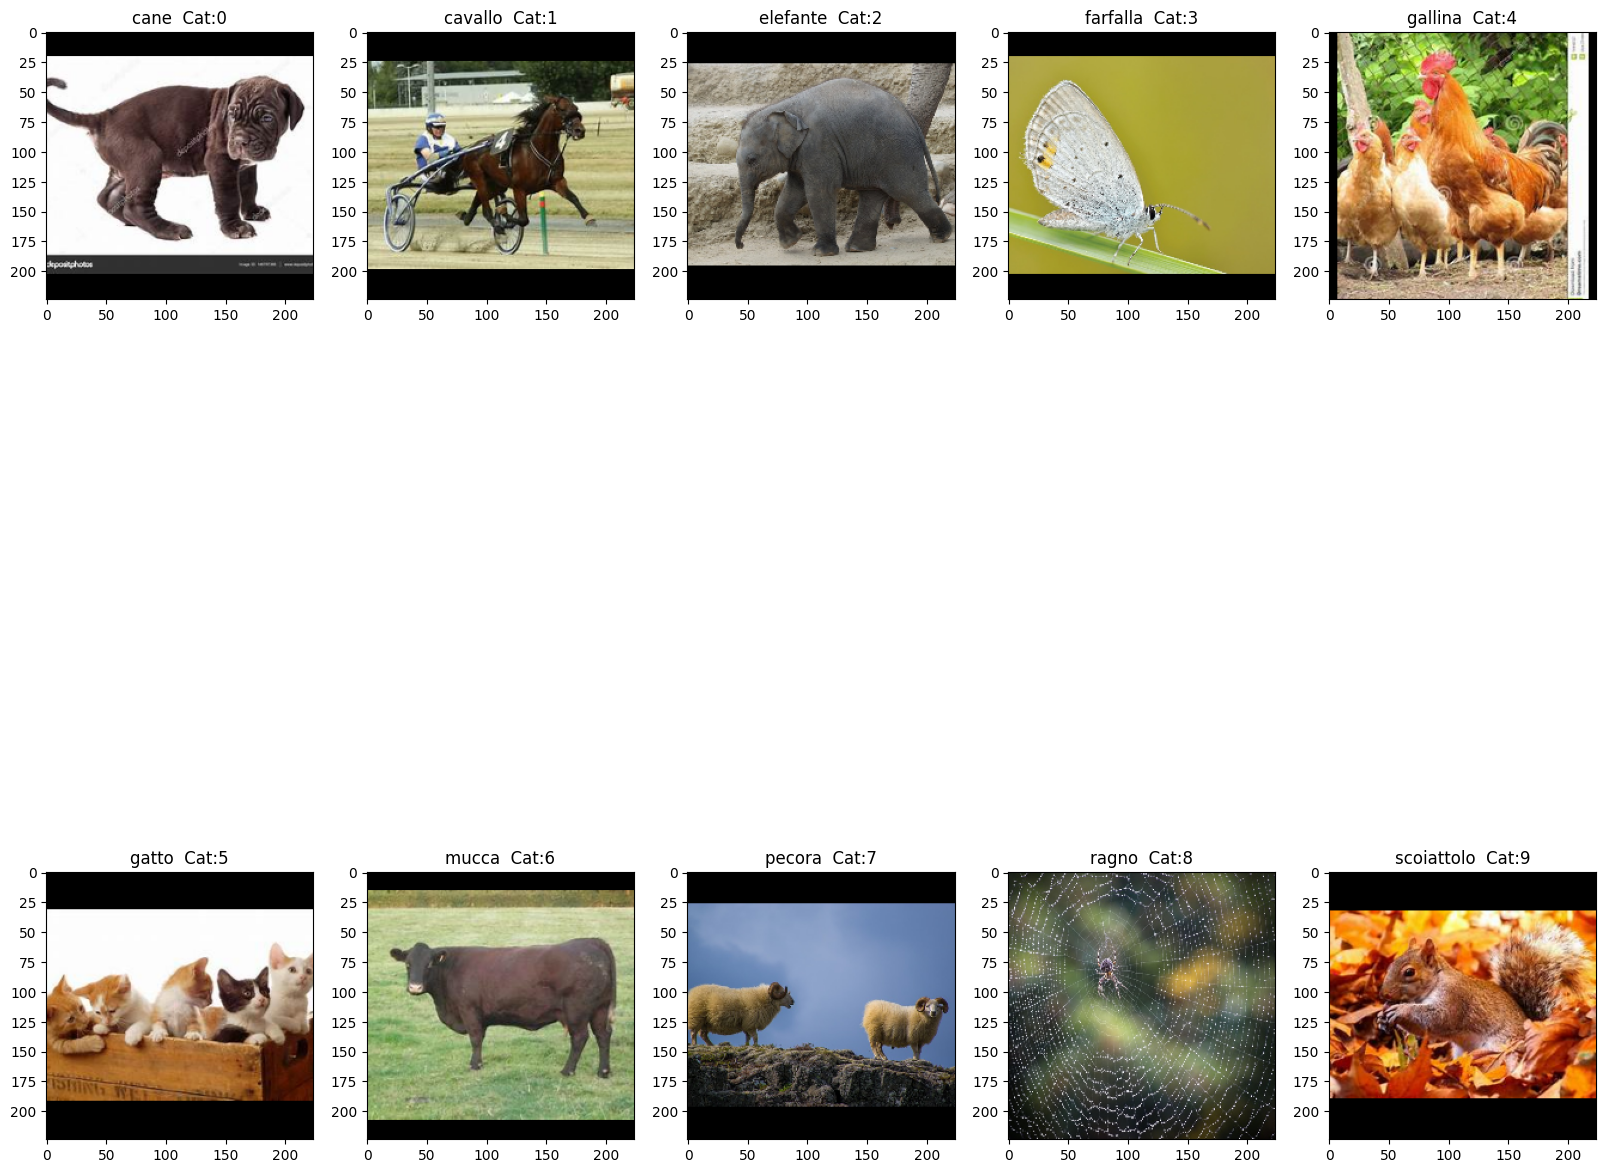

In [13]:
cols=5
fig, ax = plt.subplots(2,5, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[1] #takes path in os of 1 value of figure of each category
#     print(path)
#     image = cv2.imread(path[0])  #     [i//cols, i%cols]
    ax[i//cols, i%cols].set_title(path[0].split('/')[-2] +' '+' Cat:'+ str(path[1])) # -2 is location of name of figure in path
    ax[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [14]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [15]:
#train_test split
val_size = int(round(0.8*len(y)))
x_train = x[:val_size]
y_train = y[:val_size]
x_val = x[val_size:]
y_val = y[val_size:]

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)


y_train = to_categorical(y_train) 
y_val = to_categorical(y_val)

#dividing each intensity in array by 225 ( 225 is max intensity in RGB)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255 
x_val /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (4000, 224, 224, 3) 	 x_test Shape: (1000, 224, 224, 3)
y_train Shape:  (4000,) 	 y_test Shape: (1000,)
x_train Shape: (4000, 224, 224, 3) 	 x_test Shape: (1000, 224, 224, 3)
y_train Shape:  (4000, 10) 	 y_test Shape: (1000, 10)
image Shape: (224, 224, 3)


In [16]:
animal_names = [] 
for i in range(10):
    path = train_df[train_df.category == i].values[1]
    if path[0].split('/')[-2] == 'scoiattolo':
        animal_names.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        animal_names.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        animal_names.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        animal_names.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        animal_names.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        animal_names.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        animal_names.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        animal_names.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        animal_names.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        animal_names.append('dog')

In [19]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(rotation_range=45, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1, 
                                    horizontal_flip=True)
train_data_gen.fit(x_train) 

In [22]:
test_images = []
test_df = pd.DataFrame(columns=['filename'])
actual_pred=pd.DataFrame(columns=['Category'])
for i in range(10):
    test_df = pd.concat([test_df, df[df.category == i].iloc[500:502, :1]])
    actual_pred = pd.concat([actual_pred, df[df.category == i].iloc[500:502, 1:]]) 

    test_df = test_df.reset_index(drop=True)
    actual_pred = actual_pred.reset_index(drop=True)
with tqdm(total=len(test_df)) as k:  
    for i, file_path in enumerate(test_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)
test_images = np.array(test_images).reshape(-1,224,224,3)

C:\Users\Gaya Gopan\AppData\Local\Temp\ipykernel_14752\2089973115.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(test_df)) as k:


  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
rows,cols,channel = 224, 224, 3

epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.9
sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

base_model1 = applications.VGG16(weights='imagenet', include_top=False,
                                    input_shape=(224,224,3))
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(10, activation='softmax'))

vgg16_model = Model(inputs=base_model1.input,
                        outputs=model1(base_model1.output))

vgg16_model.compile(loss='binary_crossentropy',
                        optimizer=sgd,metrics=['accuracy'])
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
vgg16_model.summary()

C:\Users\Gaya Gopan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 10)                  │       6,425,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 21,140,042 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.8
sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)


base_model2 =ResNet50(weights=None, include_top=False, input_shape=(224,224,3))
model2 = Sequential()
model2.add(Flatten(input_shape= base_model2.output_shape[1:]))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(10, activation='softmax'))

ResNet50_model = Model(inputs=base_model2.input,
                        outputs=model2(base_model2.output))
ResNet50_model.compile(loss='binary_crossentropy',
                        optimizer= sgd,
                          metrics=['accuracy'])
ResNet50_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 49,280,650 (187.99 MB)

 Trainable params: 49,227,530 (187.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
class lr_finder():
    
    def __init__(self,model,begin_lr=1e-8, end_lr=1e-1, num_epochs=10, period=5):
        self.period = period
        # make a copy of the model to train through a sweep of learning rates
        self.model = clone_model(model)
        self.begin_lr = np.log(begin_lr)/np.log(10)
        self.end_lr = np.log(end_lr)/np.log(10)
        self.num_epochs = num_epochs
        self.lower_bound = begin_lr
        self.upper_bound = 1e-2 #end_lr
        # define learning rates to use in schedules
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        
    def reset_model(self, model):
        # reset the model to find new lr bounds 
        self.begin_lr = -10 
        self.end_lr = 0 
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.model = clone_model(model)
        
    def lr_schedule(self,epoch):
        # return lr according to a sweeping schedule
        if epoch < self.num_epochs:
            return self.lr[epoch]
        else:
            return self.lr[0]
        
    def clr_schedule(self,epoch,period=5):
        # return lr according to cyclical learning rate schedule
        my_epoch = int(epoch % self.period)
        return self.clr[my_epoch]
    
    def lr_vector(self,epochs):
        # return the vector of learning rates used in a schedule
        lrv = []
        for ck in range(epochs):
            lrv.append(self.lr_schedule(ck))
        return lrv
    
    def lr_plot(self,history_loss,please_plot=True):
        # plot the lr sweep results and set upper and lower bounds on learning rate
        x_axis = self.lr_vector(self.num_epochs)
        y_axis = history_loss
                   
        d_loss = []
        for cc in range(1,len(y_axis)):
            if cc == 1:
                d_loss.append(y_axis[cc] - y_axis[cc-1])
            else:
                d_loss.append(0.8*(y_axis[cc] - y_axis[cc-1])+0.2*(y_axis[cc-1] - y_axis[cc-2]))
        d_loss = np.array(d_loss)
        
        self.lower_bound = x_axis[d_loss.argmin()]
        self.upper_bound = x_axis[np.array(y_axis).argmin()]
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)
        
        print("recommended learning rate: more than %.2e, less than %.2e "%(self.lower_bound, self.upper_bound))
        if(please_plot):
            plt.figure(figsize=(10,5))
            plt.loglog(x_axis,y_axis)
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.title('Loss / learning rate progression')
            plt.show()
            
    def get_lr(self,epoch):
        # return the geometric mean of the upper and lower bound learning rates
        return (self.lower_bound *self.upper_bound)**(1/2)

In [31]:
def data_generator(x, y, batch_size):
    while True:
        for i in range(0, len(x), batch_size):
            batch_x = x[i:i + batch_size]
            batch_y = y[i:i + batch_size]
            yield (batch_x, batch_y)

# Use the adapted generator in the fit() method
neural_ntwk2 = ResNet50_model.fit(
    data_generator(x_train, y_train, batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[ModelCheckpoint('ResNet50transferlearning.model.keras', monitor='val_acc')]
)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3264s 26s/step - accuracy: 0.1250 - loss: 0.4282 - val_accuracy: 0.0930 - val_loss: 0.3947
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3228s 26s/step - accuracy: 0.1496 - loss: 0.3269 - val_accuracy: 0.0940 - val_loss: 0.3386
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2604s 21s/step - accuracy: 0.1584 - loss: 0.3221 - val_accuracy: 0.1310 - val_loss: 0.3302
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2562s 21s/step - accuracy: 0.1928 - loss: 0.3176 - val_accuracy: 0.1690 - val_loss: 0.3280
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2902s 23s/step - accuracy: 0.1864 - loss: 0.3141 - val_accuracy: 0.1760 - val_loss: 0.3491
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3034s 24s/step - accuracy: 0.2017 - loss: 0.3098 - val_accuracy: 0.1950 - val_loss: 0.3641
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3308s 26s/step - accuracy: 0.2280 - loss: 0.3050 - val_accuracy: 0.2070 - val_loss: 0.3272
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2856s 23s/step - accuracy: 0.2359 - loss: 0

In [47]:
test_prediction1 = vgg16_model.predict(test_images)
test_prediction2 = ResNet50_model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


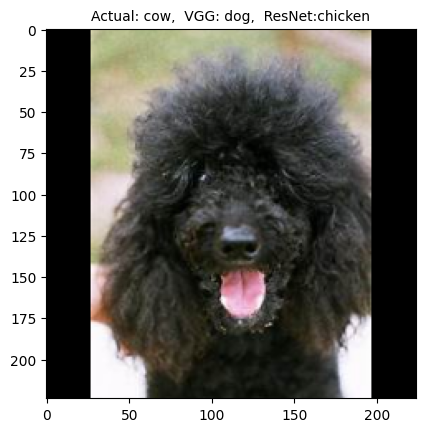

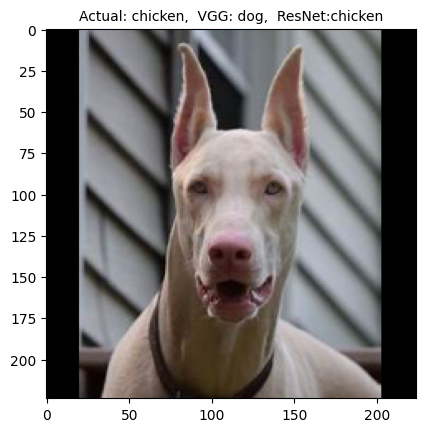

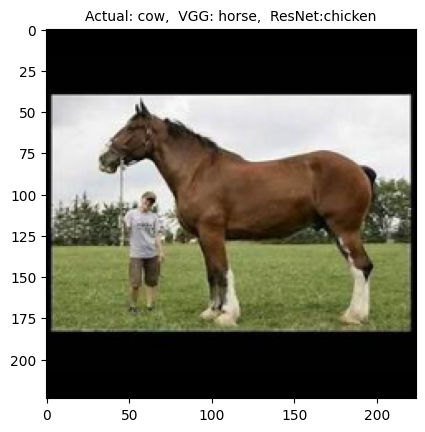

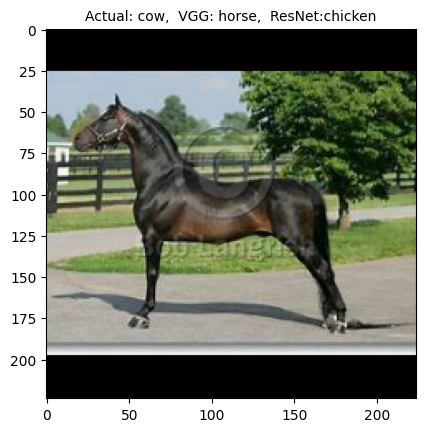

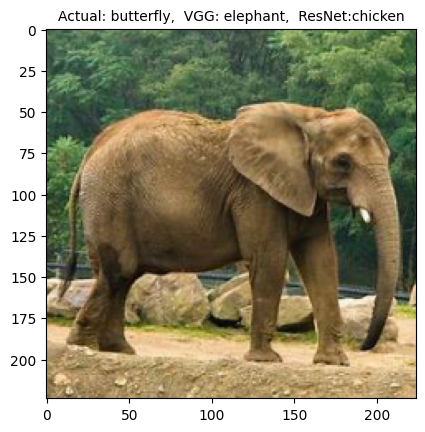

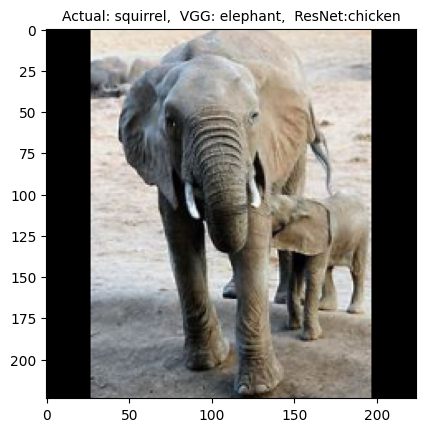

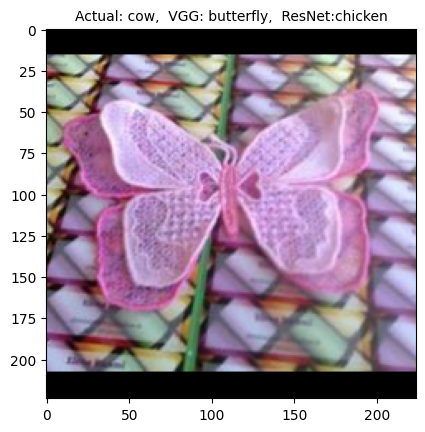

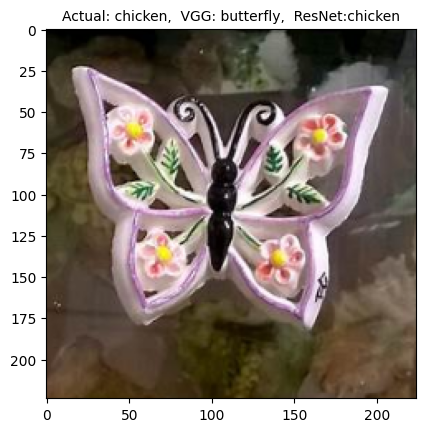

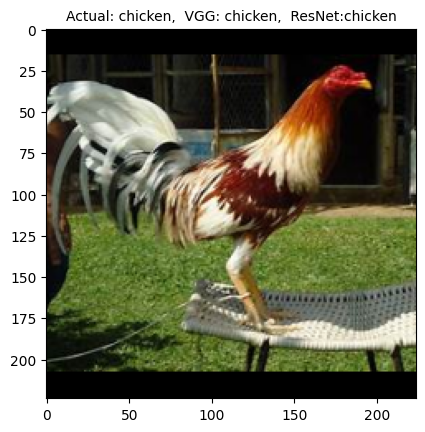

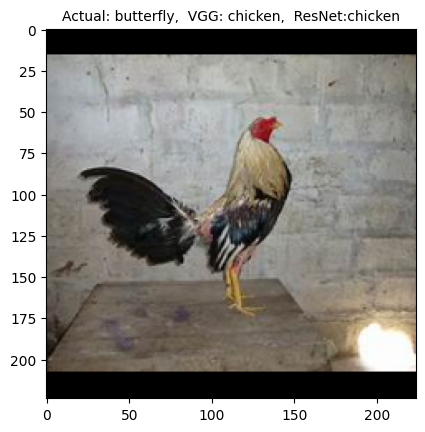

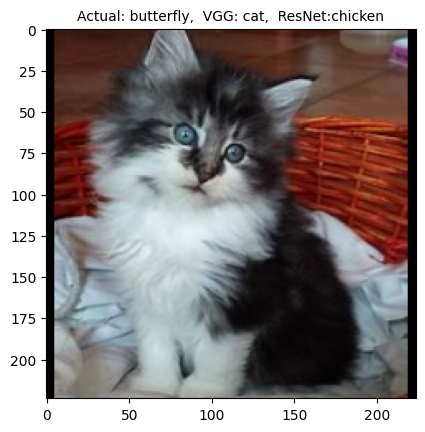

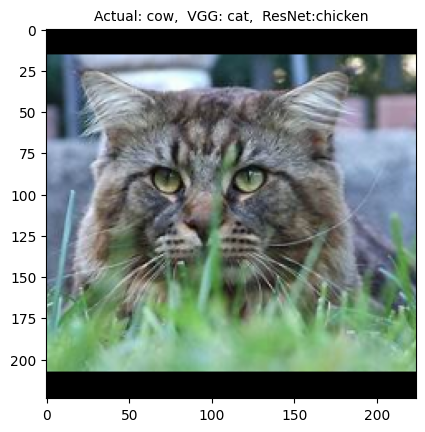

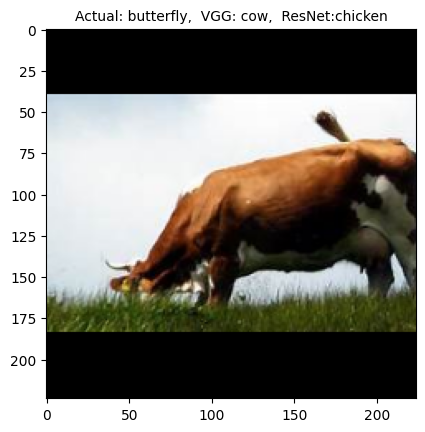

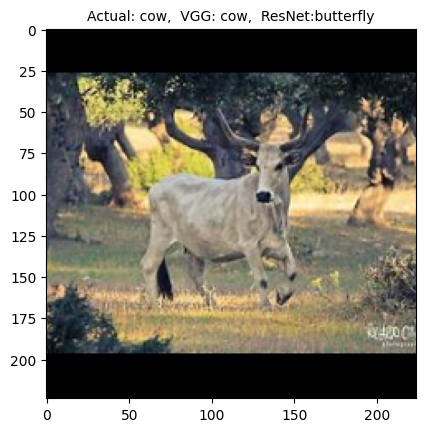

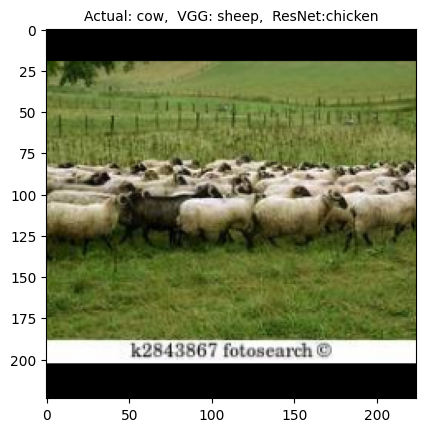

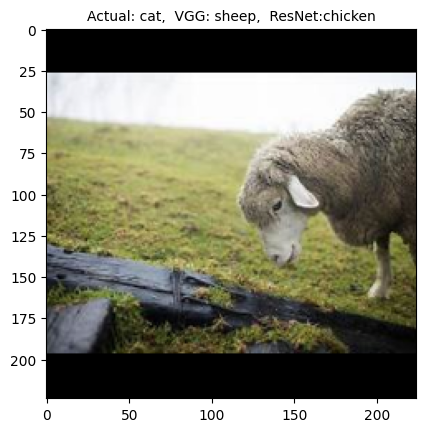

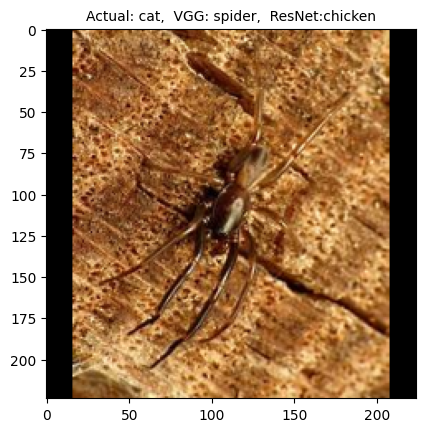

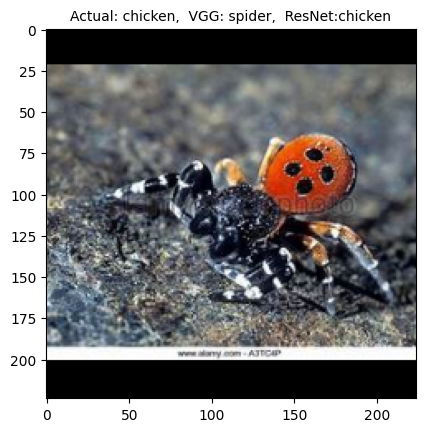

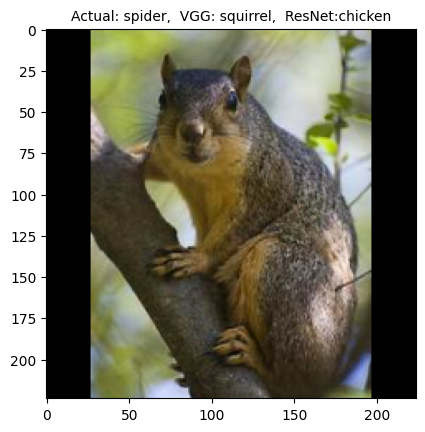

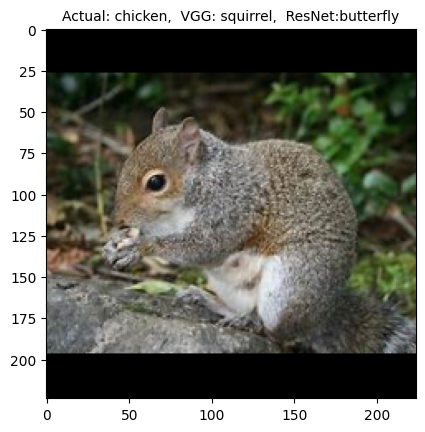

In [48]:
actual_pred['category']=actual_pred['category'].astype('int')
for i in range(20):
    predict1= test_prediction1[i].argmax()
    predict2= test_prediction2[i].argmax()
    actual=actual_pred['category'][i]
    plt.imshow(test_images[i])
    plt.title("Actual: {1},  VGG: {0},  ResNet:{2}".format((animal_names[actual]),(animal_names[predict1]),(animal_names[predict2])), fontsize=10)
    plt.show()